# PyChe Tutorial: Run + Full Diagnostics

This notebook shows in-memory analysis from `res.mod` and `res.fis`, file-based diagnostics, and MPI workflows.

It includes:
- serial in-memory run
- MPI in-memory run with `mpi_subprocess=True`
- baseline/no-approx comparison
- diagnostic plots from `res.mod` and `res.fis`
- MPI test recipes and interpretation notes


In [18]:
from pyche import GCEModel, create_diagnostic_plots, read_outputs
from pyche.diagnostics import diagnostics_from_tables
import numpy as np
import matplotlib.pyplot as plt


## 1) In-memory run (serial)


In [19]:
m = GCEModel()
res = m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=True,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
#    progress_style="single",
)
res.mod.shape, res.fis.shape


Progress [##############################] 100.00% (13700/13700)
GCE full translation run complete
ninputyield: 32
final gas: 495699.2887694819
final zeta: 0.006259913397521376
timing profile (s): total=9.783, interp=6.824, mpi_reduce=0.000, death=0.611, wind=1.865, output=0.035, other=0.448
total runtime (wall): 9.784 s


((13700, 39), (13700, 12))

## 1a) In-memory run (MPI from notebook)

Use `mpi_subprocess=True` when you want the result directly as a Python variable from a notebook cell.


In [20]:
m = GCEModel()
res = m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    show_progress=True,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
    use_mpi=True,
    mpi_subprocess=True,
    mpi_subprocess_ranks=4,
    progress_style="single",

)
res.mod.shape, res.fis.shape


'Progress [##############################] 100.00% (13700/13700)'

GCE full translation run complete
MPI ranks: 4
ninputyield: 32
final gas: 495699.2887694819
final zeta: 0.006259913397521376
timing profile (s): total=4.750, interp=1.695, mpi_reduce=0.369, death=0.606, wind=1.645, output=0.034, other=0.401
total runtime (wall, max-rank): 4.751 s



((13700, 39), (13700, 12))

## 1a-bis) Reproducing the same model with external infall and SFR-efficiency vectors

In the default setup, infall is parametric:

$$I(t) = \frac{\sigma_h\,S}{2.5\,\sigma_t}\exp\!\left[-\frac{(t-\Delta)^2}{2\sigma_t^2}\right]$$

where:
- $S$ is `superf = 20000`
- $\sigma_t$ is `sigmat`
- $\sigma_h$ is `sigmah`
- $\Delta$ is `delay`

In this section we build the same $I(t)$ externally and also pass a constant `rhosfr_values` (equivalent to scalar `psfr`).
Using `input_time` + (`infall_values`, `rhosfr_values`), we verify that diagnostics match the fully parametric run.


In [21]:
# Build external vectors equivalent to the default parametric profile
superf = 20000.0
endo = 13700
sigmat = 3000.0
sigmah = 50.0
delay = 10000
psfr0 = 0.3

input_time = np.arange(0.0, endo + 1.0, 1.0)
coeff = sigmah * superf / (2.5 * sigmat)
infall_values = coeff * np.exp(-((input_time - delay) ** 2) / (2.0 * sigmat**2))
rhosfr_values = np.full_like(input_time, psfr0, dtype=float)

m = GCEModel()
res_input_vec = m.GCE(
    endoftime=1,  # ignored when input_time is provided
    sigmat=sigmat,
    sigmah=sigmah,
    psfr=psfr0,
    pwind=0.0,
    delay=delay,
    time_wind=10000,
    input_time=input_time,
    infall_values=infall_values,
    rhosfr_values=rhosfr_values,
    use_mpi=False,
    show_progress=False,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
)

res_input_vec.mod.shape, res_input_vec.fis.shape


GCE full translation run complete
ninputyield: 32
final gas: 495699.2887694819
final zeta: 0.006259913397521376
timing profile (s): total=9.020, interp=6.606, mpi_reduce=0.000, death=0.542, wind=1.644, output=0.035, other=0.193
total runtime (wall): 9.020 s


((13700, 39), (13700, 12))

max |SFR diff| : 0.0
max |Gas diff| : 0.0
max |Zeta diff|: 0.0
max |[Fe/H] diff|: 0.0


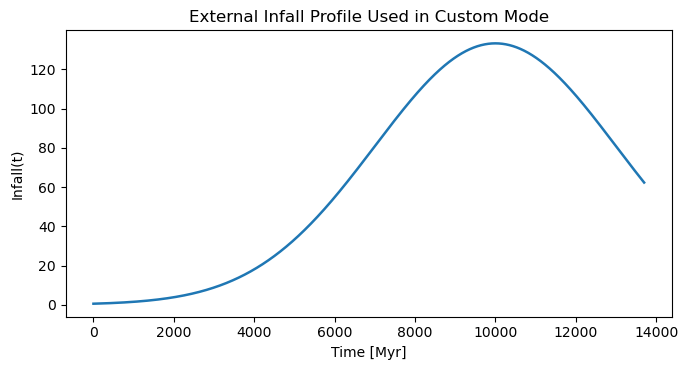

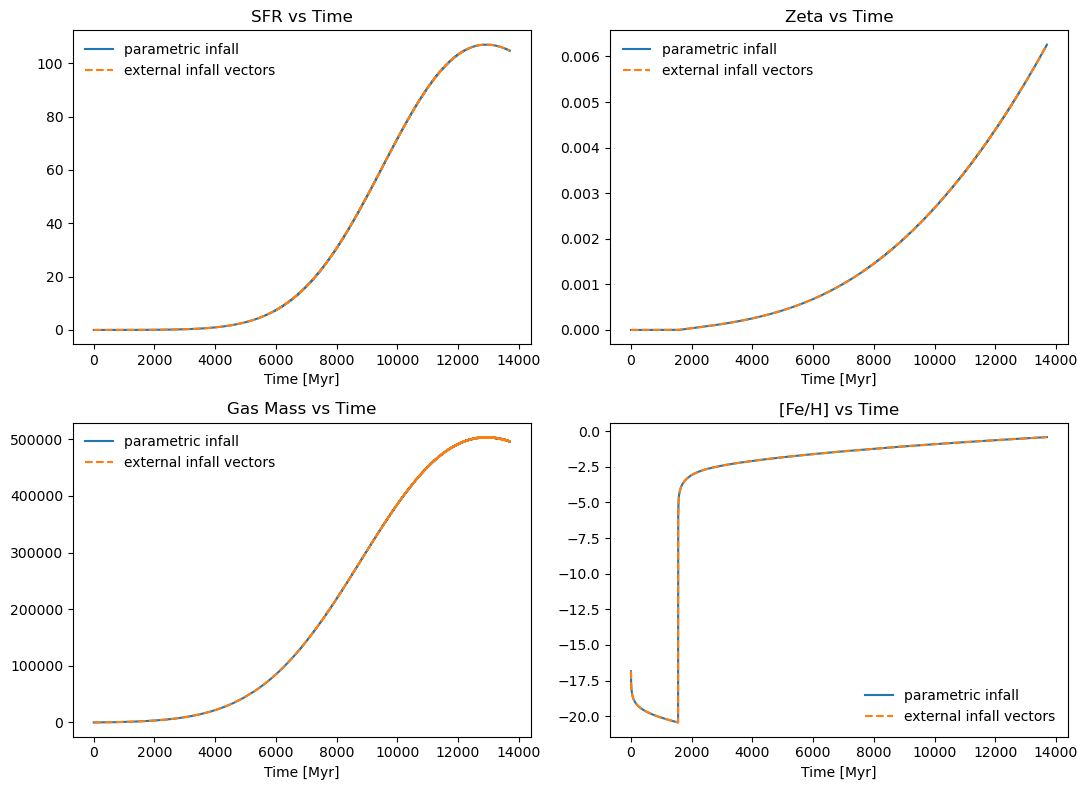

In [22]:
# Compare parametric vs external-input runs with explicit diagnostic plots
fis_cols = {name: i for i, name in enumerate(res.fis_columns)}
mod_cols = {name: i for i, name in enumerate(res.mod_columns)}

# FIS time-series
time_ref = res.fis[:, fis_cols['time']]
time_vec = res_input_vec.fis[:, fis_cols['time']]
sfr_ref = res.fis[:, fis_cols['sfr']]
sfr_vec = res_input_vec.fis[:, fis_cols['sfr']]
gas_ref = res.fis[:, fis_cols['gas']]
gas_vec = res_input_vec.fis[:, fis_cols['gas']]
zeta_ref = res.fis[:, fis_cols['zeta']]
zeta_vec = res_input_vec.fis[:, fis_cols['zeta']]

# [Fe/H] track from MOD tables
eps = 1.0e-30
FE_H_SUN_MASS = 56.0 * 10.0 ** (-4.50)

time_m_ref = res.mod[:, mod_cols['time']]
time_m_vec = res_input_vec.mod[:, mod_cols['time']]
fe_ref = res.mod[:, mod_cols['Fe']]
h_ref = res.mod[:, mod_cols['H']]
fe_vec = res_input_vec.mod[:, mod_cols['Fe']]
h_vec = res_input_vec.mod[:, mod_cols['H']]
log_feh_ref = np.log10(np.maximum(fe_ref / np.maximum(h_ref, eps), eps) / FE_H_SUN_MASS)
log_feh_vec = np.log10(np.maximum(fe_vec / np.maximum(h_vec, eps), eps) / FE_H_SUN_MASS)

# Quantitative checks
print('max |SFR diff| :', float(np.max(np.abs(sfr_ref - sfr_vec))))
print('max |Gas diff| :', float(np.max(np.abs(gas_ref - gas_vec))))
print('max |Zeta diff|:', float(np.max(np.abs(zeta_ref - zeta_vec))))
print('max |[Fe/H] diff|:', float(np.max(np.abs(log_feh_ref - log_feh_vec))))

# Plot external infall and rhosfr profiles used in custom mode
fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
ax[0].plot(input_time, infall_values, lw=1.8)
ax[0].set_title('External Infall Profile')
ax[0].set_xlabel('Time [Myr]')
ax[0].set_ylabel('Infall(t)')
ax[1].plot(input_time, rhosfr_values, lw=1.8)
ax[1].set_title(r'External $\rho_{\mathrm{SFR}}(t)$')
ax[1].set_xlabel('Time [Myr]')
ax[1].set_ylabel(r'$\rho_{\mathrm{SFR}}$')
plt.tight_layout()

# Key diagnostic overlays
fig, ax = plt.subplots(2, 2, figsize=(11, 8))

ax[0, 0].plot(time_ref, sfr_ref, label='parametric')
ax[0, 0].plot(time_vec, sfr_vec, '--', label='external input vectors')
ax[0, 0].set_title('SFR vs Time')
ax[0, 0].set_xlabel('Time [Myr]')
ax[0, 0].legend(frameon=False)

ax[0, 1].plot(time_ref, zeta_ref, label='parametric')
ax[0, 1].plot(time_vec, zeta_vec, '--', label='external input vectors')
ax[0, 1].set_title('Zeta vs Time')
ax[0, 1].set_xlabel('Time [Myr]')
ax[0, 1].legend(frameon=False)

ax[1, 0].plot(time_ref, gas_ref, label='parametric')
ax[1, 0].plot(time_vec, gas_vec, '--', label='external input vectors')
ax[1, 0].set_title('Gas Mass vs Time')
ax[1, 0].set_xlabel('Time [Myr]')
ax[1, 0].legend(frameon=False)

ax[1, 1].plot(time_m_ref, log_feh_ref, label='parametric')
ax[1, 1].plot(time_m_vec, log_feh_vec, '--', label='external input vectors')
ax[1, 1].set_title('[Fe/H] vs Time')
ax[1, 1].set_xlabel('Time [Myr]')
ax[1, 1].legend(frameon=False)

plt.tight_layout()


## 1b) Same run without approximations (baseline settings, serial)


In [23]:
m = GCEModel()
res_noapprox = m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=True,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
    adaptive_timestep=False,
    interp_cache=False,
    interp_cache_guard=False,
    profile_timing=False,
    spalla_stride=1,
    spalla_inactive_threshold=0.0,
    spalla_lut=False,
)
res_noapprox.mod.shape, res_noapprox.fis.shape


Progress [##############################] 100.00% (13700/13700)
GCE full translation run complete
ninputyield: 32
final gas: 495745.9622989858
final zeta: 0.00625895498464687
total runtime (wall): 51.112 s


((13700, 39), (13700, 12))

## 1c) Same baseline settings in MPI (optional)


In [24]:
m = GCEModel()
res_noapprox_mpi = m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    show_progress=True,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
    adaptive_timestep=False,
    interp_cache=False,
    interp_cache_guard=False,
    profile_timing=False,
    spalla_stride=1,
    spalla_inactive_threshold=0.0,
    spalla_lut=False,
    use_mpi=True,
    mpi_subprocess=True,
    mpi_subprocess_ranks=4,
)
res_noapprox_mpi.mod.shape, res_noapprox_mpi.fis.shape


'Progress [##############################] 100.00% (13700/13700)'

GCE full translation run complete
MPI ranks: 4
ninputyield: 32
final gas: 495745.9622989858
final zeta: 0.00625895498464687
total runtime (wall, max-rank): 24.962 s



((13700, 39), (13700, 12))

## 1d) Backend comparison including JAX

Run the same physical setup with `auto`, `cython`, and `jax` and compare key diagnostics.


In [ ]:
# Compare multiple backends on the same parameter set

base_kwargs = dict(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=False,
    output_mode='dataframe',
    write_output=False,
    return_results=True,
)

backend_overrides = {
    'auto': dict(),
    'cython': dict(
        interp_cache=True,
        interp_cache_mass_points=96,
        interp_cache_zeta_points=64,
        interp_cache_binmax_points=64,
    ),
    'jax': dict(
        interp_cache=True,
        interp_cache_mass_points=96,
        interp_cache_zeta_points=64,
        interp_cache_binmax_points=64,
        interp_cache_guard=True,
        interp_cache_guard_tol=0.01,
        interp_cache_guard_stride=1,
    ),
}

results = {}
for b, extra in backend_overrides.items():
    m_b = GCEModel()
    kwargs = dict(base_kwargs)
    kwargs.update(extra)
    results[b] = m_b.GCE(backend=b, **kwargs)

cols = {name: i for i, name in enumerate(results['auto'].fis_columns)}
time = results['auto'].fis[:, cols['time']]

for key in ['gas', 'zeta', 'sfr']:
    idx = cols[key]
    plt.figure(figsize=(7, 3))
    for b in ['auto', 'cython', 'jax']:
        plt.plot(time, results[b].fis[:, idx], label=b)
    plt.title(f'{key} comparison by backend')
    plt.xlabel('time')
    plt.ylabel(key)
    plt.legend()
    plt.tight_layout()
    plt.show()

auto_fis = results['auto'].fis
for b in ['cython', 'jax']:
    d = np.max(np.abs(results[b].fis - auto_fis), axis=0)
    print(f'backend={b} max |fis-auto| by column:')
    print(dict(zip(results['auto'].fis_columns, d)))

print('Final gas by backend:', {b: float(results[b].fis[-1, cols['gas']]) for b in results})
print('Final zeta by backend:', {b: float(results[b].fis[-1, cols['zeta']]) for b in results})



## 1e) JAX optimized vs JAX no-approx diagnostics

This section applies the same diagnostic tests to JAX runs: optimized settings vs no-approx baseline.


In [ ]:
# JAX runs for optimized vs no-approx diagnostic comparison
m = GCEModel()
res_jax_opt = m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=False,
    backend='jax',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
    adaptive_timestep=True,
    interp_cache=True,
    interp_cache_mass_points=96,
    interp_cache_zeta_points=64,
    interp_cache_binmax_points=64,
    interp_cache_guard=True,
    interp_cache_guard_tol=0.01,
    interp_cache_guard_stride=1,
    profile_timing=False,
)

m = GCEModel()
res_jax_noapprox = m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=False,
    backend='jax',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
    adaptive_timestep=False,
    interp_cache=False,
    interp_cache_guard=False,
    spalla_stride=1,
    spalla_inactive_threshold=0.0,
    spalla_lut=False,
    profile_timing=False,
)
res_jax_opt.mod.shape, res_jax_noapprox.mod.shape



In [ ]:
# Helper extractors for JAX optimized run and JAX no-approx run
mod_cols = {name: i for i, name in enumerate(res_jax_opt.mod_columns)}
fis_cols = {name: i for i, name in enumerate(res_jax_opt.fis_columns)}

def extract_series(r):
    time_f = r.fis[:, fis_cols['time']]
    sfr = r.fis[:, fis_cols['sfr']]
    allv = r.fis[:, fis_cols['all']]
    gas = r.fis[:, fis_cols['gas']]
    stars = r.fis[:, fis_cols['stars']]
    remn = r.fis[:, fis_cols['remn']]
    zeta = r.fis[:, fis_cols['zeta']]

    time_m = r.mod[:, mod_cols['time']]
    fe = r.mod[:, mod_cols['Fe']]
    h = r.mod[:, mod_cols['H']]
    o16 = r.mod[:, mod_cols['O16']]
    mg = r.mod[:, mod_cols['Mg']]

    eps = 1.0e-30
    FE_H_SUN_MASS = 56.0 * 10.0 ** (-4.50)
    O_FE_SUN_MASS = (16.0 / 56.0) * 10.0 ** (8.69 - 7.50)
    MG_FE_SUN_MASS = (24.305 / 56.0) * 10.0 ** (7.60 - 7.50)
    log_feh = np.log10(np.maximum(fe / np.maximum(h, eps), eps) / FE_H_SUN_MASS)
    log_o_fe = np.log10(np.maximum(o16 / np.maximum(fe, eps), eps) / O_FE_SUN_MASS)
    log_mg_fe = np.log10(np.maximum(mg / np.maximum(fe, eps), eps) / MG_FE_SUN_MASS)

    stars_delta = np.diff(stars, prepend=stars[0])
    stars_delta = np.maximum(stars_delta, 0.0)
    mdf_mask = np.isfinite(log_feh) & (log_feh >= -5.0) & (log_feh <= 1.0)

    return {
        'time_f': time_f, 'sfr': sfr, 'allv': allv, 'gas': gas, 'stars': stars, 'remn': remn, 'zeta': zeta,
        'time_m': time_m, 'log_feh': log_feh, 'log_o_fe': log_o_fe, 'log_mg_fe': log_mg_fe,
        'stars_delta': stars_delta, 'mdf_mask': mdf_mask,
    }

opt = extract_series(res_jax_opt)
base = extract_series(res_jax_noapprox)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(opt['time_f'], opt['sfr'], label='jax optimized')
ax[0].plot(base['time_f'], base['sfr'], '--', label='jax no_approx')
ax[0].set_title('SFR vs Time')
ax[0].legend(frameon=False)
ax[1].plot(opt['time_f'], opt['zeta'], label='jax optimized')
ax[1].plot(base['time_f'], base['zeta'], '--', label='jax no_approx')
ax[1].set_title('Zeta vs Time')
ax[1].legend(frameon=False)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 4))
for name in ['allv','gas','stars','remn']:
    ax.plot(opt['time_f'], opt[name], label=f'{name} opt')
    ax.plot(base['time_f'], base[name], '--', label=f'{name} base')
ax.set_title('Mass Budget Evolution (JAX)')
ax.legend(frameon=False, ncols=2, fontsize=8)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(opt['time_m'], opt['log_feh'], lw=1.4, label='jax optimized')
ax.plot(base['time_m'], base['log_feh'], '--', lw=1.2, label='jax no_approx')
ax.set_title('[Fe/H] vs Time (JAX)')
ax.set_ylim(-7, 0.8)
ax.legend(frameon=False)
plt.tight_layout()

mask_opt = np.isfinite(opt['log_feh'])
mask_base = np.isfinite(base['log_feh'])
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(opt['log_feh'][mask_opt], opt['log_o_fe'][mask_opt], label='[O/Fe] opt', lw=1.3)
ax.plot(base['log_feh'][mask_base], base['log_o_fe'][mask_base], '--', label='[O/Fe] base', lw=1.1)
ax.plot(opt['log_feh'][mask_opt], opt['log_mg_fe'][mask_opt], label='[Mg/Fe] opt', lw=1.3)
ax.plot(base['log_feh'][mask_base], base['log_mg_fe'][mask_base], '--', label='[Mg/Fe] base', lw=1.1)
ax.set_title('Abundance Tracks (JAX)')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[X/Fe]')
ax.set_xlim(-5, 1)
ax.set_ylim(-0.1, 0.8)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()

bins = np.linspace(-5, 1, 61)
w_opt = opt['stars_delta'][opt['mdf_mask']].copy()
w_base = base['stars_delta'][base['mdf_mask']].copy()
if np.sum(w_opt) > 0:
    w_opt /= np.sum(w_opt)
if np.sum(w_base) > 0:
    w_base /= np.sum(w_base)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(opt['log_feh'][opt['mdf_mask']], bins=bins, weights=w_opt, alpha=0.5, label='jax optimized')
ax.hist(base['log_feh'][base['mdf_mask']], bins=bins, weights=w_base, alpha=0.5, label='jax no_approx')
ax.set_title('MDF [Fe/H] (JAX)')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Normalized Stellar-Mass Fraction')
ax.legend(frameon=False)
plt.tight_layout()



## Output column names


In [25]:
print('mod columns:', res.mod_columns)
print('fis columns:', res.fis_columns)


mod columns: ('time', 'all', 'gas', 'stars', 'sfr', 'oldstars', 'HeN', 'C12', 'O16', 'N14', 'C13', 'Ne', 'Mg', 'Si', 'Fe', 'S14', 'C13S', 'S32', 'Ca', 'Remn', 'Zn', 'K', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'La', 'Ba', 'Eu', 'Sr', 'Y', 'Zr', 'Rb', 'Li', 'H', 'He4')
fis columns: ('time', 'all', 'gas', 'stars', 'remn', 'hot', 'zeta', 'sfr', 'nume', 'sfr2', 'snia_num', 'snia_rate')


## 2) Diagnostics from in-memory arrays


In [26]:
diag = diagnostics_from_tables(res.mod, res.fis)
diag


{'n_steps': 13700,
 'final_gas': 495699.2887694819,
 'final_stars': 377456.8844201444,
 'final_remn': 20874.495996126032,
 'final_zeta': 0.006259913397521376,
 'max_sfr': 107.0331463726102,
 'checks': {'gas_nonnegative': True,
  'stars_nonnegative': True,
  'remn_nonnegative': True,
  'all_nonnegative': True},
 'all_checks_pass': True}

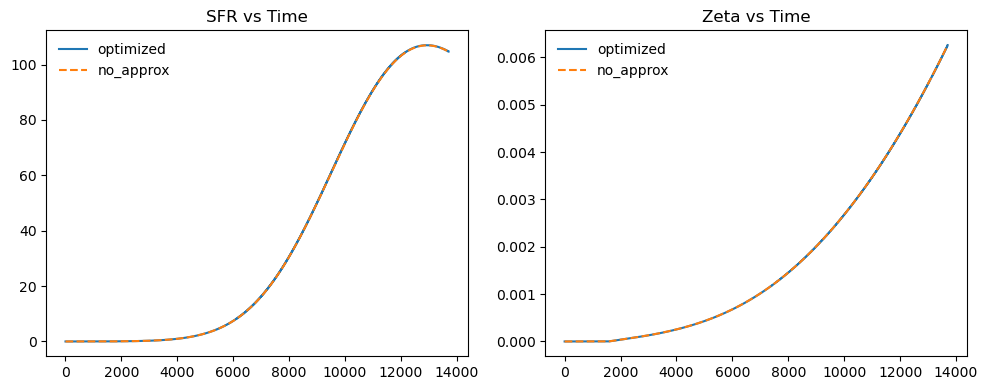

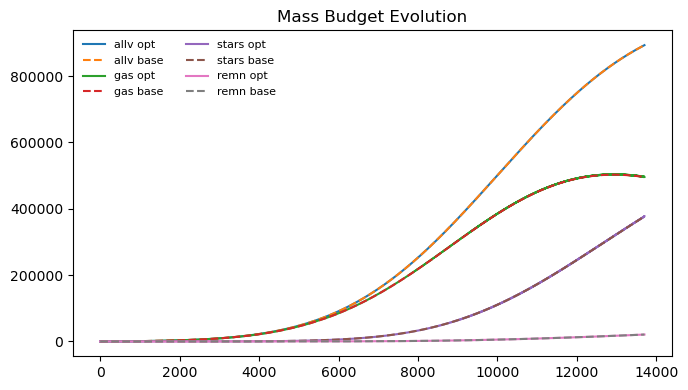

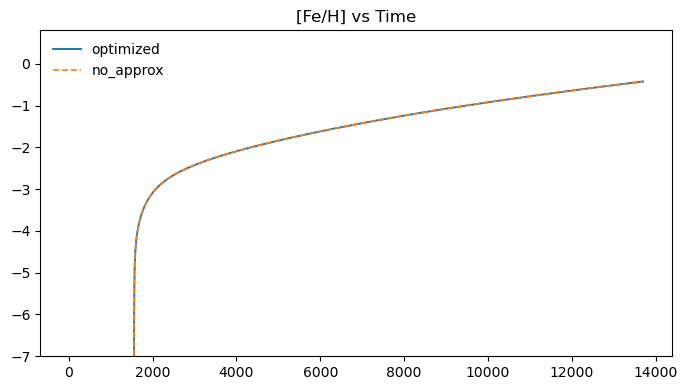

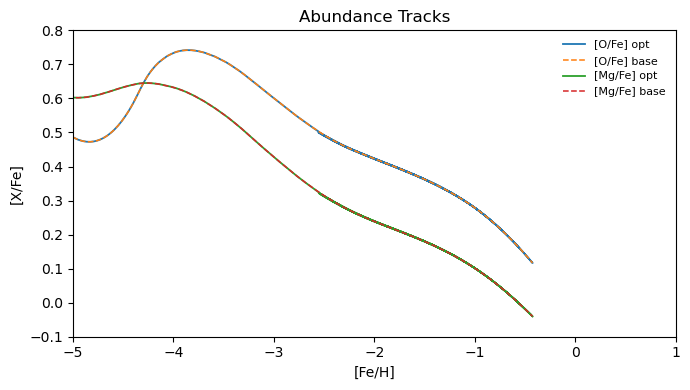

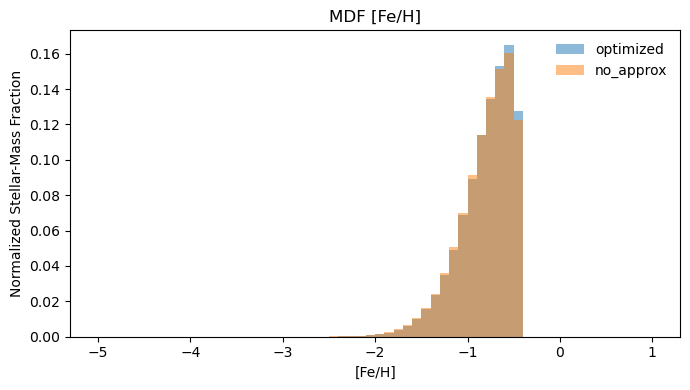

In [27]:
# Helper extractors for optimized run and no-approx run
mod_cols = {name: i for i, name in enumerate(res.mod_columns)}
fis_cols = {name: i for i, name in enumerate(res.fis_columns)}

def extract_series(r):
    time_f = r.fis[:, fis_cols['time']]
    sfr = r.fis[:, fis_cols['sfr']]
    allv = r.fis[:, fis_cols['all']]
    gas = r.fis[:, fis_cols['gas']]
    stars = r.fis[:, fis_cols['stars']]
    remn = r.fis[:, fis_cols['remn']]
    zeta = r.fis[:, fis_cols['zeta']]

    time_m = r.mod[:, mod_cols['time']]
    fe = r.mod[:, mod_cols['Fe']]
    h = r.mod[:, mod_cols['H']]
    o16 = r.mod[:, mod_cols['O16']]
    mg = r.mod[:, mod_cols['Mg']]

    eps = 1.0e-30
    FE_H_SUN_MASS = 56.0 * 10.0 ** (-4.50)
    O_FE_SUN_MASS = (16.0 / 56.0) * 10.0 ** (8.69 - 7.50)
    MG_FE_SUN_MASS = (24.305 / 56.0) * 10.0 ** (7.60 - 7.50)
    log_feh = np.log10(np.maximum(fe / np.maximum(h, eps), eps) / FE_H_SUN_MASS)
    log_o_fe = np.log10(np.maximum(o16 / np.maximum(fe, eps), eps) / O_FE_SUN_MASS)
    log_mg_fe = np.log10(np.maximum(mg / np.maximum(fe, eps), eps) / MG_FE_SUN_MASS)

    stars_delta = np.diff(stars, prepend=stars[0])
    stars_delta = np.maximum(stars_delta, 0.0)
    mdf_mask = np.isfinite(log_feh) & (log_feh >= -5.0) & (log_feh <= 1.0)

    return {
        'time_f': time_f, 'sfr': sfr, 'allv': allv, 'gas': gas, 'stars': stars, 'remn': remn, 'zeta': zeta,
        'time_m': time_m, 'log_feh': log_feh, 'log_o_fe': log_o_fe, 'log_mg_fe': log_mg_fe,
        'stars_delta': stars_delta, 'mdf_mask': mdf_mask,
    }

opt = extract_series(res)
base = extract_series(res_noapprox)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(opt['time_f'], opt['sfr'], label='optimized')
ax[0].plot(base['time_f'], base['sfr'], '--', label='no_approx')
ax[0].set_title('SFR vs Time')
ax[0].legend(frameon=False)
ax[1].plot(opt['time_f'], opt['zeta'], label='optimized')
ax[1].plot(base['time_f'], base['zeta'], '--', label='no_approx')
ax[1].set_title('Zeta vs Time')
ax[1].legend(frameon=False)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 4))
for name in ['allv','gas','stars','remn']:
    ax.plot(opt['time_f'], opt[name], label=f'{name} opt')
    ax.plot(base['time_f'], base[name], '--', label=f'{name} base')
ax.set_title('Mass Budget Evolution')
ax.legend(frameon=False, ncols=2, fontsize=8)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(opt['time_m'], opt['log_feh'], lw=1.4, label='optimized')
ax.plot(base['time_m'], base['log_feh'], '--', lw=1.2, label='no_approx')
ax.set_title('[Fe/H] vs Time')
ax.set_ylim(-7,0.8)
ax.legend(frameon=False)
plt.tight_layout()

mask_opt = np.isfinite(opt['log_feh'])
mask_base = np.isfinite(base['log_feh'])
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(opt['log_feh'][mask_opt], opt['log_o_fe'][mask_opt], label='[O/Fe] opt', lw=1.3)
ax.plot(base['log_feh'][mask_base], base['log_o_fe'][mask_base], '--', label='[O/Fe] base', lw=1.1)
ax.plot(opt['log_feh'][mask_opt], opt['log_mg_fe'][mask_opt], label='[Mg/Fe] opt', lw=1.3)
ax.plot(base['log_feh'][mask_base], base['log_mg_fe'][mask_base], '--', label='[Mg/Fe] base', lw=1.1)
ax.set_title('Abundance Tracks')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[X/Fe]')
ax.set_xlim(-5,1)
ax.set_ylim(-0.1,0.8)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()

bins = np.linspace(-5, 1, 61)
w_opt = opt['stars_delta'][opt['mdf_mask']].copy()
w_base = base['stars_delta'][base['mdf_mask']].copy()
if np.sum(w_opt) > 0:
    w_opt /= np.sum(w_opt)
if np.sum(w_base) > 0:
    w_base /= np.sum(w_base)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(opt['log_feh'][opt['mdf_mask']], bins=bins, weights=w_opt, alpha=0.5, label='optimized')
ax.hist(base['log_feh'][base['mdf_mask']], bins=bins, weights=w_base, alpha=0.5, label='no_approx')
ax.set_title('MDF [Fe/H]')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Normalized Stellar-Mass Fraction')
ax.legend(frameon=False)
plt.tight_layout()


## 3) Save a run, load it back, and create plot files


In [ ]:
out_dir = 'RISULTATI_PYCHE_NOTEBOOK'
m.GCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=False,
    output_dir=out_dir,
    output_mode='dataframe',
    df_binary_format='pickle',
    write_output=True,
    return_results=False,
)
payload = read_outputs(out_dir, prefer='dataframe', binary_format='pickle')
payload['mod'].shape, payload['fis'].shape, payload['format']

paths = create_diagnostic_plots(out_dir, prefer='dataframe', binary_format='pickle')
paths


## 4) MPI test recipes (4 ranks)

### A) Recommended production run (shell)
```bash
mpiexec -n 4 python -c "from pyche import GCEModel; m=GCEModel(); m.GCE(13700,3000.0,50.0,0.3,0.0,10000,10000,use_mpi=True,show_progress=False,backend='auto',output_dir='RISULTATI_MPI4',output_mode='dataframe',df_binary_format='pickle')"
```

### B) Cython backend (compile first)
```bash
pip install cython
python setup.py build_ext --inplace
mpiexec -n 4 python -c "from pyche import GCEModel; m=GCEModel(); m.GCE(13700,3000.0,50.0,0.3,0.0,10000,10000,use_mpi=True,show_progress=False,backend='cython',output_dir='RISULTATI_MPI4_CY',output_mode='dataframe',df_binary_format='pickle')"
```

### MPI test notes
- For fair speed tests, set `show_progress=False` (progress output adds overhead).
- Compare serial vs MPI with identical physics flags (`adaptive_timestep`, cache/guard, LUT flags).
- Use at least 2 runs and compare wall time from the printed `total runtime (wall, max-rank)`.
- If MPI output appears buffered in notebook environments, prefer `mpi_subprocess=True` or run from a shell.
- If `mpi4py` warns about MPI mismatch, rebuild `mpi4py` with the same MPI implementation used by `mpiexec`.
